In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib.colors as mcolors

from scipy.interpolate import BSpline, CubicSpline

plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams['axes.unicode_minus'] = False

pd.set_option('display.float_format', lambda x: '%.3f' % x)


short_bucket = [0, 31, 92, 182, 273]
commercial_bank = [
    '국민은행', '신한은행', '우리은행', '하나은행', '외환은행']


In [9]:
def info_merge(merge: pd.DataFrame) -> None:
    print(merge.shape)
    print(merge.columns)
    print(merge["_merge"].value_counts())
    print(merge["_merge"].value_counts() / merge.shape[0]* 100)

Risk Free

In [10]:
ecos = pd.read_csv("시장금리(일별)_22134723.csv").replace("-", None)
ecos = ecos.melt(id_vars=["계정항목"], var_name="date", value_name="yield")
ecos["date"] = pd.to_datetime(ecos["date"], errors="coerce")
ecos = ecos.dropna(subset=["date"])
ecos = ecos.pivot_table(index="date", columns="계정항목", values="yield").astype(float)
ecos = ecos.reset_index()
ecos.set_index('date', drop=True, inplace=True)

ecos_call = ecos.iloc[:, [1, 12,14,16,18, 11, 13, 15, 17]]
ecos_call.columns = [str(1/365)] + (ecos_call.columns[1:]).str.extract(r'(\d+)').squeeze().to_list()
ecos_call = ecos_call.astype(float)

ecos_kofr = ecos.iloc[:, [6, 12,14,16,18, 11, 13, 15, 17]]
ecos_kofr.columns = [str(1/365)] + (ecos_kofr.columns[1:]).str.extract(r'(\d+)').squeeze().to_list()
ecos_kofr = ecos_kofr.astype(float)

C:\Users\DYK\AppData\Local\Temp\ipykernel_23500\2086932698.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ecos["date"] = pd.to_datetime(ecos["date"], errors="coerce")


In [11]:
ecos_call

,0.0027397260273972603,1,2,3,5,10,20,30,50
date,,,,,,,,,
2001-01-02,5.280,6.680,NaN,6.670,6.880,7.180,NaN,NaN,NaN
2001-01-03,5.280,6.630,NaN,6.640,6.840,7.150,NaN,NaN,NaN
2001-01-04,5.300,6.380,NaN,6.370,6.500,6.850,NaN,NaN,NaN
2001-01-05,5.340,6.170,NaN,6.190,6.300,6.680,NaN,NaN,NaN
2001-01-08,5.320,6.090,NaN,6.100,6.250,6.600,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2024-12-16,3.022,2.691,2.665,2.553,2.655,2.721,2.648,2.573,2.474
2024-12-17,3.011,2.704,2.715,2.621,2.731,2.790,2.722,2.654,2.547
2024-12-18,3.018,2.664,2.632,2.536,2.650,2.738,2.707,2.640,2.532


In [12]:
ecos_kofr

,0.0027397260273972603,1,2,3,5,10,20,30,50
date,,,,,,,,,
2001-01-02,NaN,6.680,NaN,6.670,6.880,7.180,NaN,NaN,NaN
2001-01-03,NaN,6.630,NaN,6.640,6.840,7.150,NaN,NaN,NaN
2001-01-04,NaN,6.380,NaN,6.370,6.500,6.850,NaN,NaN,NaN
2001-01-05,NaN,6.170,NaN,6.190,6.300,6.680,NaN,NaN,NaN
2001-01-08,NaN,6.090,NaN,6.100,6.250,6.600,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2024-12-16,3.025,2.691,2.665,2.553,2.655,2.721,2.648,2.573,2.474
2024-12-17,3.016,2.704,2.715,2.621,2.731,2.790,2.722,2.654,2.547
2024-12-18,2.982,2.664,2.632,2.536,2.650,2.738,2.707,2.640,2.532


In [41]:
t = range(0, 366*10+1)

def interpolate_cubicspline(g):
    g = g.dropna()
    X = g['Maturity']*365  # Convert days to years for the x-axis
    Y = g['Yield']*100

    if(len(X)<2) : return None

    spline = CubicSpline(X, Y)

    return pd.Series(spline(t))

rfr_call = ecos_call.reset_index().melt(id_vars=['date'], var_name='Maturity', value_name='Yield')
rfr_call['Maturity'] = rfr_call['Maturity'].astype(float).astype(int)
rfr_call = rfr_call.groupby('date').apply(interpolate_cubicspline)
rfr_call = rfr_call.dropna()

rfr_kofr = ecos_kofr.reset_index().melt(id_vars=['date'], var_name='Maturity', value_name='Yield')
rfr_kofr['Maturity'] = rfr_kofr['Maturity'].astype(float).astype(int)
rfr_kofr = rfr_kofr.groupby('date').apply(interpolate_cubicspline)
rfr_kofr = rfr_kofr.dropna()


C:\Users\DYK\AppData\Local\Temp\ipykernel_23500\4193516408.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rfr_call = rfr_call.groupby('date').apply(interpolate_cubicspline)
C:\Users\DYK\AppData\Local\Temp\ipykernel_23500\4193516408.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rfr_kofr = rfr_kofr.groupby('date').apply(interpolate_cubicspline)


In [42]:
rfr_call = rfr_call.reset_index()
rfr_call['date'] = pd.to_datetime(rfr_call['date'])
rfr_call = rfr_call.melt(id_vars=['date'], var_name='TimeToMaturity', value_name='RFR_Call')
rfr_call['TimeToMaturity'] = rfr_call['TimeToMaturity'].astype(int)
rfr_call.set_index(['date', 'TimeToMaturity'], inplace=True)

rfr_kofr = rfr_kofr.reset_index()
rfr_kofr['date'] = pd.to_datetime(rfr_kofr['date'])
rfr_kofr = rfr_kofr.melt(id_vars=['date'], var_name='TimeToMaturity', value_name='RFR_KOFR')
rfr_kofr['TimeToMaturity'] = rfr_kofr['TimeToMaturity'].astype(int)
rfr_kofr.set_index(['date', 'TimeToMaturity'], inplace=True)


#### CD

In [94]:
seibro = pd.read_csv("seibro\seibro_cd_issue.csv")
seibro["기준일자"] = pd.to_datetime(seibro["기준일자"], format="%Y%m%d").dt.strftime("%Y-%m-%d")

issue = pd.read_csv("seibro\seibro_cd_issue_detail.csv")
issue.loc[issue["VALAT_GRD_CD_NM"]=="취소", "VALAT_GRD_CD_NM"] = None
issue = issue.sort_values(["발행은행신용등급","VALAT_GRD_CD_NM"]).drop_duplicates(subset=["종목코드"])
issue = pd.merge(
    issue, seibro[["종목번호", "발행인유형"]].drop_duplicates(), 
    left_on="종목코드", right_on="종목번호", how="left")
issue = issue[issue["발행통화"]=="KRW"]

issue["days_to_maturity"] = pd.to_datetime(issue["만기일"]) - pd.to_datetime(issue["발행일"])
issue["days_to_maturity"] = issue["days_to_maturity"].dt.days
issue = issue[issue["days_to_maturity"] <= 250]

trans = pd.read_csv("seibro/seibro_cd_trans.csv").drop(
    columns=["NUM", "증권구분", "date"])

merge = pd.merge(
    trans, issue, on=["종목번호"], how="left", validate="m:1", indicator=True
).drop(
    columns=["종목명_y", "발행일_y", "만기일_y"]
).rename(
    columns={
    "SETL_AMT": "매매금액",
    "종목명_x": "종목명", "발행일_x": "발행일", "만기일_x": "만기일",
})
merge = merge[merge["통화"]=="KRW"]
merge = merge[merge["발행인유형"]=="시중은행"]
merge = merge.drop(columns=[
    "통화", "발행인유형", "SHORTM_FNCEGD_CD", "SELLER_INDTP_TPCD", "BUYER_INDTP_TPCD", "발행통화", "발행은행코드",
    "잔존만기", "days_to_maturity"
])
merge = merge[merge["종목명"].str.contains(r"(국민|신한|우리|하나|외환)", na=False, regex=True)]

merge = merge[merge["매매금액"] > 0]
merge = merge[merge["발행은행신용등급"]=="AAA0(A1)"]
merge = merge.reset_index(drop=True)

merge["기준일자"] = pd.to_datetime(merge["기준일자"], format="%Y%m%d")
merge["만기일"] = pd.to_datetime(merge["만기일"], format="%Y%m%d")
merge["times_to_maturity"] = merge["만기일"] - merge["기준일자"]
merge["times_to_maturity"] = merge["times_to_maturity"].dt.days

merge["금리"] = merge["금리"].astype(float)
merge["기준일자"] = pd.to_datetime(merge["기준일자"], format="%Y%m%d")

print(merge["기준일자"].min(), merge["기준일자"].max())


info_merge(merge)

2012-05-24 00:00:00 2024-11-14 00:00:00
(29934, 29)
Index(['기준일자', '매도유형', '매수유형', '매매금액', '금리', '종목번호', '종목명', '발행일', '만기일',
       'GOODS_LEF_XPIR_TPCD', '발행은행', 'ISSUCO_CUSTNO', 'REP_SECN_NM', '종목코드',
       '액면금액', '매출금액', '발행금액', '할인율', '잔존일물', '발행형태', '지급은행지점코드',
       'PAY_BANK_MOFNO', '발행은행신용등급', '지급은행', 'CREDITRT_DT', 'VALAT_GRD_CD_NM',
       '등록일자', '_merge', 'times_to_maturity'],
      dtype='object')
_merge
both          29934
left_only         0
right_only        0
Name: count, dtype: int64
_merge
both         100.000
left_only      0.000
right_only     0.000
Name: count, dtype: float64


C:\Users\DYK\AppData\Local\Temp\ipykernel_23500\497260841.py:34: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  merge = merge[merge["종목명"].str.contains(r"(국민|신한|우리|하나|외환)", na=False, regex=True)]


#### Curve

In [95]:
cd = merge

In [96]:
rfr_call

,,RFR_Call
date,TimeToMaturity,
2001-01-02,0,528.000
2001-01-03,0,528.000
2001-01-04,0,530.000
2001-01-05,0,534.000
2001-01-08,0,532.000
...,...,...
2024-12-16,3660,272.044
2024-12-17,3660,278.940
2024-12-18,3660,273.759


In [97]:
cd_call[[
    "종목명", "기준일자", "매매금액", "times_to_maturity", "금리", "RFR_Call"
]]

,종목명,기준일자,매매금액,times_to_maturity,금리,RFR_Call
0,외환 자금부 20120524-61-1,2012-05-24,9942672999,61,3.450,328.431
1,외환 자금부 20120524-61-1,2012-05-24,9942672999,61,3.450,328.431
2,외환 자금부 20120524-61-1,2012-05-24,9942672999,61,3.450,328.431
3,외환 자금부 20120524-61-1,2012-05-24,19885345998,61,3.450,328.431
4,외환 자금부 20120524-61-1,2012-05-24,29828018997,61,3.450,328.431
...,...,...,...,...,...,...
29929,KB국민 자금부 20240828-91-1,2024-11-14,4994147953,13,3.290,323.482
29930,KB국민 자금부 20240927-91-1,2024-11-14,19921846320,43,3.330,316.885
29931,KB국민 자금부 20240927-91-1,2024-11-14,19921846320,43,3.330,316.885
29932,KB국민 자금부 20240930-91-1,2024-11-14,19916416528,46,3.330,316.270


In [98]:
cd["기준월"] = cd["기준일자"].dt.to_period("M")
cd_call = pd.merge(cd, rfr_call, left_on=['기준일자', 'times_to_maturity'], right_index=True, how='left')
cd_call["spread"] = cd_call["금리"]*100 - cd_call["RFR_Call"]

cd_kofr = pd.merge(cd, rfr_kofr, left_on=['기준일자', 'times_to_maturity'], right_index=True, how='left')
cd_kofr["spread"] = cd_kofr["금리"]*100 - cd_kofr["RFR_KOFR"]

cd_call["spread"].describe(), cd_kofr["spread"].describe()

(count   29934.000
 mean       21.889
 std        20.127
 min      -105.868
 25%         9.339
 50%        17.438
 75%        28.601
 max       137.212
 Name: spread, dtype: float64,
 count   29934.000
 mean       21.869
 std        22.225
 min      -107.834
 25%         6.763
 50%        18.023
 75%        31.530
 max       136.874
 Name: spread, dtype: float64)

In [99]:
cd_call.loc[cd_call['spread']<-20, '종목명'].unique()

array(['국민 ALM부 20200807-364-1', 'KB국민 트레저리부 20211109-364-1',
       '우리 여의도중앙기업영업지원팀 20220428-153-2',
       '하나 금융기관영업유닛(기관사업섹션 20211118-365-1', 'KB국민 트레저리부 20211209-365-1',
       '하나 금융기관영업유닛(기관사업부) 20221114-92-1',
       '하나 금융기관영업유닛(기관사업부) 20221117-99-2', 'KB국민 자금부 20230309-61-1'],
      dtype=object)

In [100]:
cd_kofr.loc[cd_kofr['spread']<-30, '종목명'].unique()

array(['KEB하나 기관영업부(금융기관영업팀) 20161007-63-1', '우리 여의도금융센터 20160901-124-2',
       '국민 ALM부 20191212-183-1', '우리 여의도중앙기업영업지원팀 20200406-85-1',
       '우리 여의도중앙기업영업지원팀 20200513-61-1', '우리 여의도기업영업지원팀 20200131-181-1',
       '국민 ALM부 20191204-275-1', '우리 여의도중앙기업영업지원팀 20210802-94-1',
       'KB국민 자금부 20220502-92-1', '하나 금융기관영업유닛(기관사업섹션 20220428-96-1',
       'KB국민 트레저리부 20211109-364-1', '우리 여의도중앙기업영업지원팀 20220428-153-2',
       '하나 금융기관영업유닛(기관사업섹션 20211118-365-1', 'KB국민 트레저리부 20211209-365-1',
       'KB국민 자금부 20230309-61-1'], dtype=object)

In [101]:
bins = [0, 31, 92, 182, 250]
labels = ["0-1m", "1-3m", "3-6m", "6-9m"]
cd_call['times_to_maturity_range'] = pd.cut(cd_call['times_to_maturity'], bins=bins, labels=labels, right=False)
cd_kofr['times_to_maturity_range'] = pd.cut(cd_kofr['times_to_maturity'], bins=bins, labels=labels, right=False)


In [102]:
cd_kofr['times_to_maturity_range'].value_counts()

times_to_maturity_range
1-3m    8771
3-6m    6997
0-1m    6172
6-9m    2424
Name: count, dtype: int64

In [ ]:
# Step 4: Function to calculate the weighted average
def weighted_average(values, weights):
    # Ensure the inputs are NumPy arrays for element-wise operations
    values = np.array(values)
    weights = np.array(weights)
    
    # Compute the weighted average
    weighted_sum = np.sum(values * weights)  # Sum of weighted values
    total_weight = np.sum(weights)  # Total sum of weights
    
    # Avoid division by zero
    if total_weight == 0:
        return None
    
    return weighted_sum / total_weight


grouped_call = cd_call.groupby(['기준월', 'times_to_maturity_range']).apply(
    lambda group: weighted_average(group['spread'], group['매매금액'])
).reset_index(name='credit_spread')

grouped_repo = cd_repo.groupby(['기준월', 'times_to_maturity_range']).apply(
    lambda group: weighted_average(group['spread'], group['매매금액'])
).reset_index(name='credit_spread')


# Step 6: Pivot the data for plotting (separating by time_to_maturity_range)
pivoted_call = grouped_call.pivot(index='기준월', columns='times_to_maturity_range', values='credit_spread')
pivoted_repo = grouped_repo.pivot(index='기준월', columns='times_to_maturity_range', values='credit_spread')

C:\Users\DYK\AppData\Local\Temp\ipykernel_23500\1323637414.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_call = cd_call.groupby(['기준월', 'times_to_maturity_range']).apply(
C:\Users\DYK\AppData\Local\Temp\ipykernel_23500\1323637414.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_call = cd_call.groupby(['기준월', 'times_to_maturity_range']).apply(
C:\Users\DYK\AppData\Local\Temp\ipykernel_23500\1323637414.py:22: FutureWarning: The default of observed=False is deprecated and will be chan

In [112]:
def plot_credit_spread(pivoted, title):
    plt.figure(figsize=(14, 7))

    # Line plot for each time-to-maturity range
    color_palette = ['#E69F00', '#56B4E9', '#009E73', '#F0E442', '#D55E00']
    style_palette = ['-', '--', '-.', ':']
    for c in pivoted.columns:
        pivoted[c].plot(kind='line', label=c, color=color_palette.pop(0), linestyle=style_palette.pop(0))

    # Set title and labels
    plt.title(f'Monthly Volume-weighted-average Spread: {title}', fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Spread (basis points)', fontsize=12)
    plt.grid()

    # Set x-axis ticks to show only the years (with year intervals, not months)
    # Extract only the years from the '거래월' index, which is a PeriodIndex (year-month)
    years = [str(period.year) for period in pivoted.index]

    # Set xticks to show only the unique years, with a label for each year
    #plt.xticks(ticks=range(0, len(pivoted.index), 12), labels=years[::12], rotation=45)

    # Add legend
    plt.legend(title='Time to Maturity Bucket')
    plt.axhline(y=0, color='red', linewidth=0.5)

    # Display the plot
    plt.tight_layout()
    plt.show()

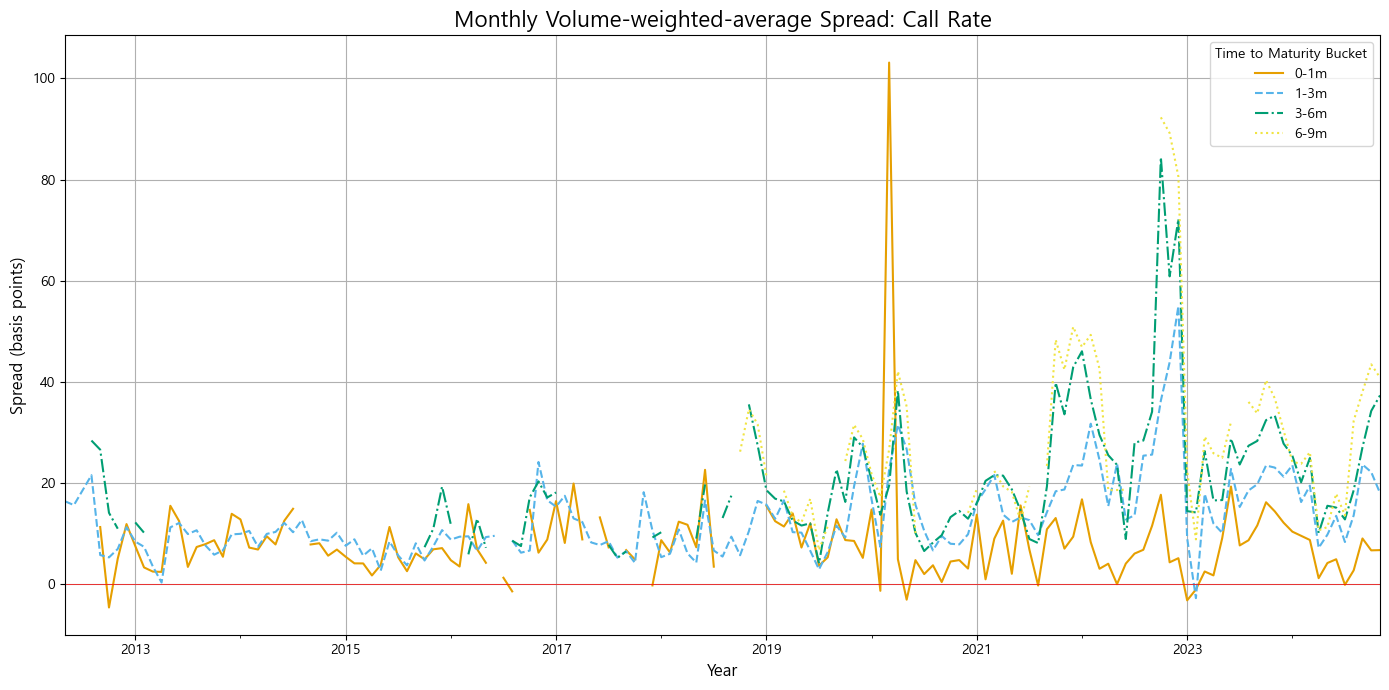

In [113]:
plot_credit_spread(pivoted_call, "Call Rate")

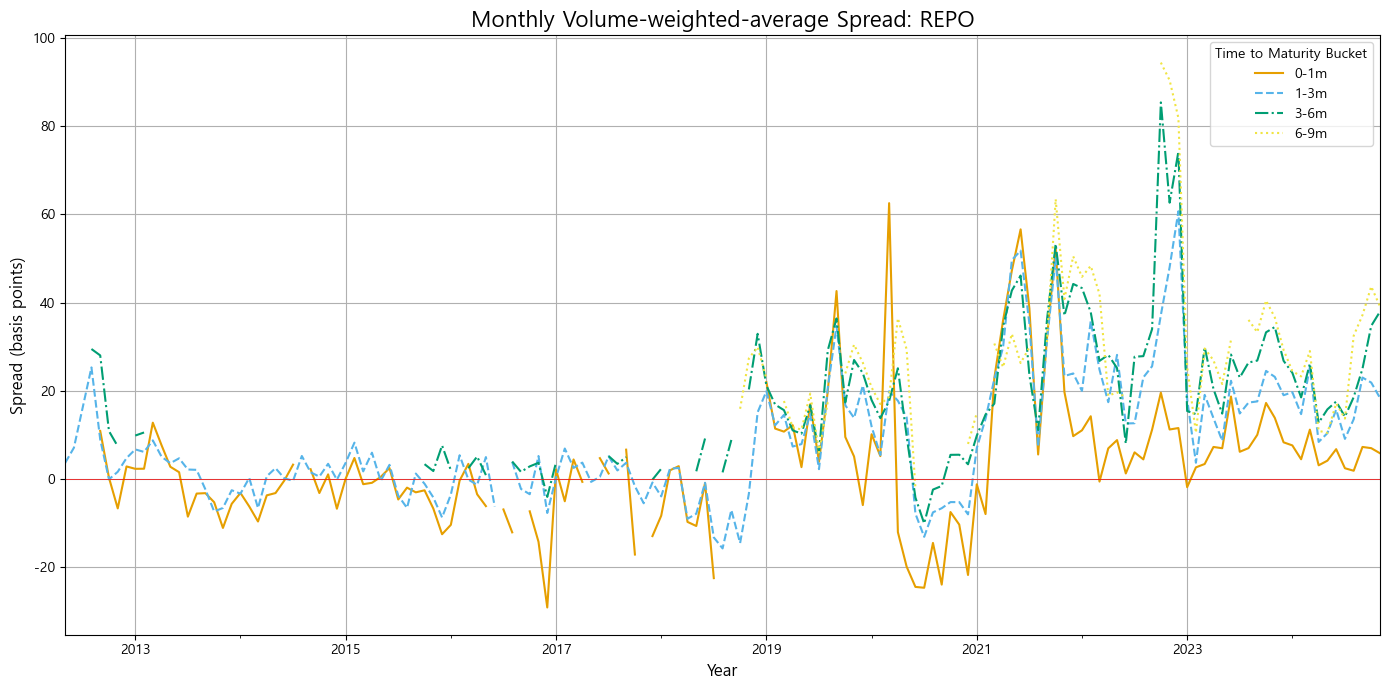

In [114]:
plot_credit_spread(pivoted_repo, "REPO")

In [ ]:

plot_yield_curve([rfr_call, rfr_kofr], ["Call Rate", "KOFIR"], "2023-01-01", year=10, dif_size=True)